## Market1501 / cuhk03 

{'UMPM': {'password': 'ahJaka4o', 'username': 'umpmuser'},
 'data_root': '/media/julian/Maxtor/DATA/pak'}



/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


/media/julian/Maxtor/DATA/pak/cuhk03_release found :)
/media/julian/Maxtor/DATA/pak/Market-1501-v15.09.15 found :)
/media/julian/Maxtor/DATA/pak/DukeMTMC-reID found :)
found memmaped /media/julian/Maxtor/DATA/pak/cuhk03_release/labeled221x221.npy
(cuhk) positive test pairs: 9290
(cuhk) positive train pairs: 127242
(market) positive test pairs:  300631
(market) positive train pairs:  309874
load memmap /media/julian/Maxtor/DATA/pak/DukeMTMC-reID/bounding_box_test221x221.npy
load memmap /media/julian/Maxtor/DATA/pak/DukeMTMC-reID/bounding_box_train221x221.npy
(duke) positive test pairs:  926089
(duke) positive train pairs:  749270
(6, 221, 221, 6)
is same: [1 0]
is same: [0 1]
is same: [0 1]
is same: [1 0]
is same: [0 1]
is same: [1 0]


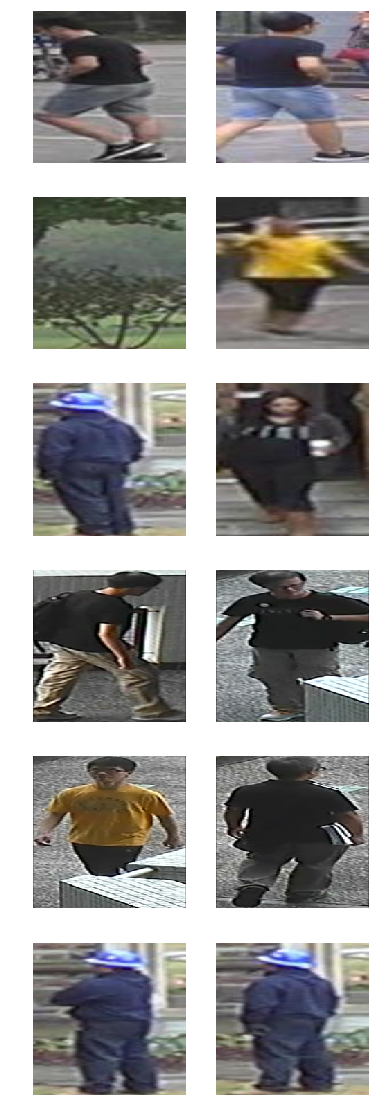

In [1]:
%matplotlib inline
import json
from pprint import pprint
Settings = json.load(open('settings.txt'))
pprint(Settings)
print('')
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
from reid.stacknet import get_model
from reid.data import DataSampler

from keras.callbacks import ModelCheckpoint, TerminateOnNaN
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
from os.path import join, isfile, isdir, exists, splitext

root = Settings['data_root']

# target_w = 221
# target_h = 221
target_w = 221
target_h = 221


sampler = DataSampler(root, target_w, target_h)

npos = 3
nneg = 3
x, y = sampler.get_test_batch(npos, nneg)
#n = npos + nneg
n = len(x)
print(x.shape)

fig = plt.figure(figsize=(6, 20))
for pid in range(n):
    print('is same:', y[pid])
    im = x[pid]
    ax = fig.add_subplot(n, 2, pid*2+1); ax.axis('off')
    ax.imshow(im[:,:,0:3])
    ax = fig.add_subplot(n, 2, pid*2+2); ax.axis('off')
    ax.imshow(im[:,:,3:6])
plt.show()

## UMPM dataset

/media/julian/Maxtor/DATA/pak
UMPM
elapsed 2.9042346477508545
same [0 1]
(32, 221, 221, 6)


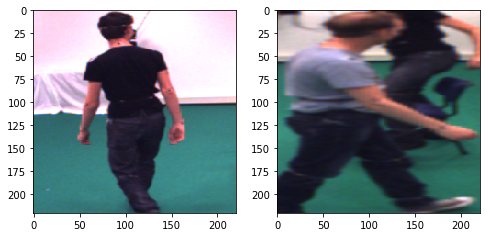

In [2]:
from time import time
from reid.data import UMPMSampler

root = Settings['data_root']
print(root)

user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']
umpm_sampler = UMPMSampler(root, ['p2_chair_2'], user, pwd, target_w, target_h)


_start = time()
x, y = umpm_sampler.get_train()
_end = time()
print('elapsed', _end - _start)

print('same', y[0])

print(x.shape)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(121)
ax.imshow(x[0, :, :, 0:3].astype('uint8'))
ax = fig.add_subplot(122)
ax.imshow(x[0, :, :, 3:6].astype('uint8'))
plt.show()

## MOT16 dataset

/media/julian/Maxtor/DATA/pak/MOT16 found :)
MOT16: load memmapped file /media/julian/Maxtor/DATA/pak/MOT16/train/MOT16-02/data.memmap
MOT16 X loaded
MOT16 Y_det loaded
MOT16 Y_gt loaded
(MOT16) total number of bounding boxes: 1736
elapsed 10.660199403762817
same [0 1]


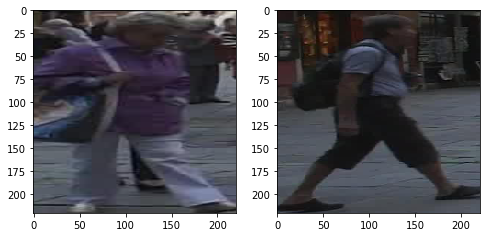

In [3]:
from reid.data import MOT16Sampler

mot_sampler = MOT16Sampler(root, target_w, target_h)


_start = time()
x, y = mot_sampler.sample()
_end = time()
print('elapsed', _end - _start)

print('same', y[0])

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(121)
ax.imshow(x[0,:,:,0:3].astype('uint8'))
ax = fig.add_subplot(122)
ax.imshow(x[0,:,:,3:6].astype('uint8'))
plt.show()

/media/julian/Maxtor/DATA/pak/MOT16 found :)
MOT16: load memmapped file /media/julian/Maxtor/DATA/pak/MOT16/train/MOT16-02/data.memmap
MOT16 X loaded
MOT16 Y_det loaded
MOT16 Y_gt loaded
(MOT16) total number of bounding boxes: 1736
UMPM
/media/julian/Maxtor/DATA/pak/cuhk03_release found :)
/media/julian/Maxtor/DATA/pak/Market-1501-v15.09.15 found :)
/media/julian/Maxtor/DATA/pak/DukeMTMC-reID found :)
found memmaped /media/julian/Maxtor/DATA/pak/cuhk03_release/labeled221x221.npy
(cuhk) positive test pairs: 9290
(cuhk) positive train pairs: 127242
(market) positive test pairs:  300631
(market) positive train pairs:  309874
load memmap /media/julian/Maxtor/DATA/pak/DukeMTMC-reID/bounding_box_test221x221.npy
load memmap /media/julian/Maxtor/DATA/pak/DukeMTMC-reID/bounding_box_train221x221.npy
(duke) positive test pairs:  926089
(duke) positive train pairs:  749270
------------


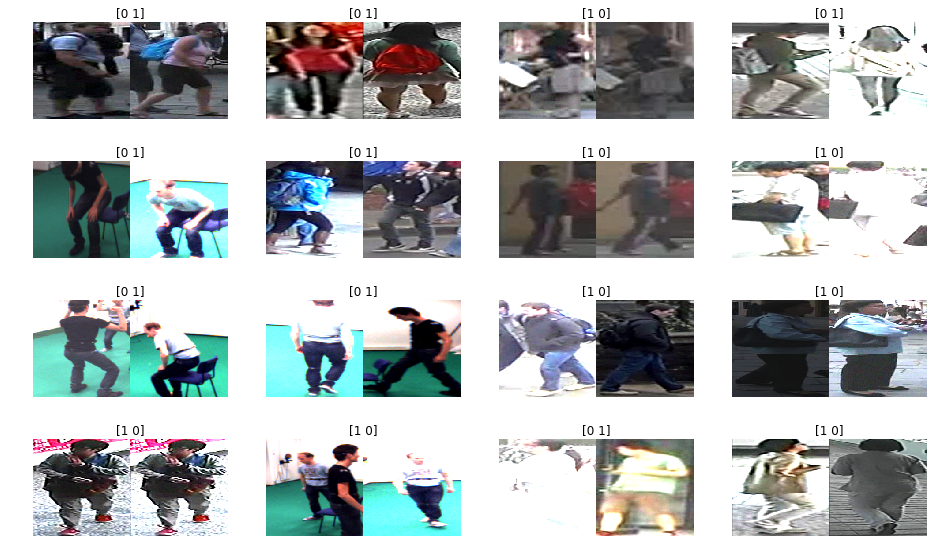

In [4]:
from reid.data import Data
import numpy as np
root = Settings['data_root']
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']


sampler = Data(root, target_w, target_h, user, pwd)
print('------------')


x, y = sampler.train()

fig = plt.figure(figsize=(16,20))
for idx, im in enumerate(x):
    ax = fig.add_subplot(8, 4, idx+1); ax.axis('off')
    Im = np.concatenate([im[:,:,0:3], im[:,:,3:6]], axis=1).astype('uint8')
    ax.imshow(Im)
    ax.set_title(str(y[idx]))
    
plt.show()

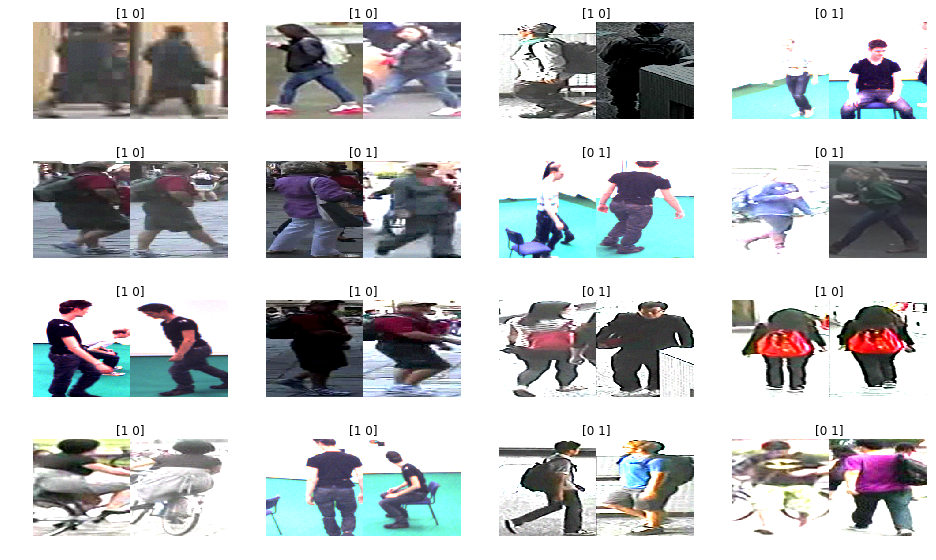

In [5]:
x, y = sampler.train()

fig = plt.figure(figsize=(16,20))
for idx, im in enumerate(x):
    ax = fig.add_subplot(8, 4, idx+1); ax.axis('off')
    Im = np.concatenate([im[:,:,0:3], im[:,:,3:6]], axis=1).astype('uint8')
    ax.imshow(Im)
    ax.set_title(str(y[idx]))
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


y: 1


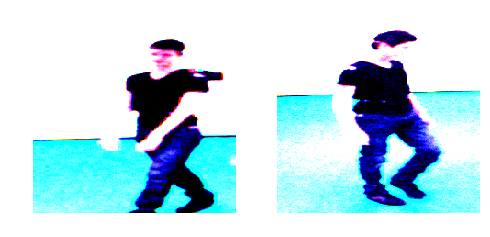

In [6]:
from keras.applications.densenet import preprocess_input

def generate_training():
    global sampler
    while True:
        X, Y = sampler.train(add_noise=True)
        X_a = preprocess_input(X[:,:,:,0:3])
        X_b = preprocess_input(X[:,:,:,3:6])
        yield ([X_a, X_b], Y[:, 0])
        
def generate_test():
    global sampler
    while True:
        X, Y = sampler.test()
        X_a = preprocess_input(X[:,:,:,0:3])
        X_b = preprocess_input(X[:,:,:,3:6])
        yield ([X_a, X_b], Y[:, 0])

        
# ------------------------
gen = generate_training()

(Xa, Xb), Y = next(gen)

i = 0
print("y:", Y[i])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(121); ax.axis("off")
ax.imshow(Xa[i])
ax = fig.add_subplot(122); ax.axis("off")
ax.imshow(Xb[i])

plt.show()

In [7]:
print(np.min(Xa), np.max(Xa))
print(np.min(Xb), np.max(Xb))

-2.1179039301310043 2.6399999999999997
-2.1179039301310043 2.6399999999999997


## Training

In [7]:
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda, Flatten, concatenate
from keras.optimizers import RMSprop
from keras import backend as K
from keras.models import load_model

filepath = join(root, 'model_heavy.h5')
print('model:', filepath)

if isfile(filepath):
    model = load_model(filepath)
else:
    seq = Sequential()
    seq.add(DenseNet121(weights='imagenet', input_shape=(221, 221, 3),
        include_top=False, pooling='avg'))
    seq.add(Flatten())

    input_a = Input(shape=(221, 221, 3))
    input_b = Input(shape=(221, 221, 3))

    out_a = seq(input_a)
    out_b = seq(input_b)

    concatenated = concatenate([out_a, out_b])
    hidden_drp1 = Dropout(0.5)(concatenated)
    hidden = Dense(32, activation='relu')(hidden_drp1)
    hidden_drp2 = Dropout(0.5)(hidden)
    out = Dense(1, activation='sigmoid')(hidden_drp2)

    model = Model([input_a, input_b], out)

model: /home/DATA/model_heavy.h5


In [ ]:
from keras.optimizers import SGD, RMSprop, Nadam, Adam, Adadelta

#optimizer = Nadam()
#optimizer = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = Nadam(lr=0.00001)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy', 'acc']

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 221, 221, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 221, 221, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1024)         7037504     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2048)         0           sequential_1[1][0]               
          

In [ ]:
from keras.callbacks import ModelCheckpoint, TerminateOnNaN

checkpoint = ModelCheckpoint(filepath, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, mode='min')
callbacks_list = [checkpoint, TerminateOnNaN()]

history = model.fit_generator(generate_training(), 
                             validation_data=generate_test(),
                             validation_steps=5,
                             steps_per_epoch=100,
                             epochs=2000,
                             callbacks=callbacks_list)

acc = history.history['val_binary_accuracy']
tacc = history.history['binary_accuracy']

plt.plot(range(len(acc)), acc)
plt.plot(range(len(tacc)), tacc)
plt.show()

Epoch 1/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.9909 - binary_accuracy: 0.5044 - acc: 0.5044
Epoch 00001: loss improved from inf to 0.98799, saving model to /home/DATA/model_heavy.h5
100/100 [==============================] - 71s 709ms/step - loss: 0.9880 - binary_accuracy: 0.5069 - acc: 0.5069 - val_loss: 0.7260 - val_binary_accuracy: 0.5750 - val_acc: 0.5750
Epoch 2/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.9249 - binary_accuracy: 0.5297 - acc: 0.5297
Epoch 00002: loss improved from 0.98799 to 0.92335, saving model to /home/DATA/model_heavy.h5
100/100 [==============================] - 42s 415ms/step - loss: 0.9233 - binary_accuracy: 0.5300 - acc: 0.5300 - val_loss: 0.7127 - val_binary_accuracy: 0.5500 - val_acc: 0.5500
Epoch 3/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.9146 - binary_accuracy: 0.5076 - acc: 0.5076
Epoch 00003: loss improved from 0.92335 to 0.91210, saving model to /home/DATA/model_heavy.h5
100/1

100/100 [==============================] - 42s 419ms/step - loss: 0.7225 - binary_accuracy: 0.5500 - acc: 0.5500 - val_loss: 0.6931 - val_binary_accuracy: 0.5000 - val_acc: 0.5000
Epoch 24/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.7238 - binary_accuracy: 0.5455 - acc: 0.5455
Epoch 00024: loss did not improve
100/100 [==============================] - 41s 411ms/step - loss: 0.7244 - binary_accuracy: 0.5463 - acc: 0.5463 - val_loss: 0.6930 - val_binary_accuracy: 0.5250 - val_acc: 0.5250
Epoch 25/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.7391 - binary_accuracy: 0.5309 - acc: 0.5309
Epoch 00025: loss did not improve
100/100 [==============================] - 41s 411ms/step - loss: 0.7399 - binary_accuracy: 0.5300 - acc: 0.5300 - val_loss: 0.6932 - val_binary_accuracy: 0.4875 - val_acc: 0.4875
Epoch 26/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.7187 - binary_accuracy: 0.5429 - acc: 0.5429
Epoch 00026: loss improved from 

Epoch 47/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.6852 - binary_accuracy: 0.5581 - acc: 0.5581
Epoch 00047: loss did not improve
100/100 [==============================] - 41s 413ms/step - loss: 0.6861 - binary_accuracy: 0.5550 - acc: 0.5550 - val_loss: 0.6932 - val_binary_accuracy: 0.5000 - val_acc: 0.5000
Epoch 48/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.6796 - binary_accuracy: 0.5480 - acc: 0.5480
Epoch 00048: loss improved from 0.68074 to 0.67884, saving model to /home/DATA/model_heavy.h5
100/100 [==============================] - 42s 421ms/step - loss: 0.6788 - binary_accuracy: 0.5500 - acc: 0.5500 - val_loss: 0.6931 - val_binary_accuracy: 0.5125 - val_acc: 0.5125
Epoch 49/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.6943 - binary_accuracy: 0.5322 - acc: 0.5322
Epoch 00049: loss did not improve
100/100 [==============================] - 42s 416ms/step - loss: 0.6918 - binary_accuracy: 0.5350 - acc: 0.5350 - val

Epoch 71/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.6492 - binary_accuracy: 0.5694 - acc: 0.5694
Epoch 00071: loss did not improve
100/100 [==============================] - 41s 409ms/step - loss: 0.6488 - binary_accuracy: 0.5694 - acc: 0.5694 - val_loss: 0.6933 - val_binary_accuracy: 0.4750 - val_acc: 0.4750
Epoch 72/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.6590 - binary_accuracy: 0.5619 - acc: 0.5619
Epoch 00072: loss did not improve
100/100 [==============================] - 40s 402ms/step - loss: 0.6589 - binary_accuracy: 0.5619 - acc: 0.5619 - val_loss: 0.6932 - val_binary_accuracy: 0.5000 - val_acc: 0.5000
Epoch 73/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.6356 - binary_accuracy: 0.5865 - acc: 0.5865
Epoch 00073: loss improved from 0.64596 to 0.63471, saving model to /home/DATA/model_heavy.h5
100/100 [==============================] - 42s 421ms/step - loss: 0.6347 - binary_accuracy: 0.5850 - acc: 0.5850 - val

Epoch 117/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.4824 - binary_accuracy: 0.7045 - acc: 0.7045
Epoch 00117: loss improved from 0.50472 to 0.48140, saving model to /home/DATA/model_heavy.h5
100/100 [==============================] - 41s 412ms/step - loss: 0.4814 - binary_accuracy: 0.7062 - acc: 0.7062 - val_loss: 0.6930 - val_binary_accuracy: 0.5250 - val_acc: 0.5250
Epoch 118/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.5139 - binary_accuracy: 0.6989 - acc: 0.6989
Epoch 00118: loss did not improve
100/100 [==============================] - 40s 402ms/step - loss: 0.5138 - binary_accuracy: 0.6981 - acc: 0.6981 - val_loss: 0.5292 - val_binary_accuracy: 0.6625 - val_acc: 0.6625
Epoch 119/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.5123 - binary_accuracy: 0.6951 - acc: 0.6951
Epoch 00119: loss did not improve
100/100 [==============================] - 40s 404ms/step - loss: 0.5115 - binary_accuracy: 0.6956 - acc: 0.6956 - 

Epoch 165/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.4466 - binary_accuracy: 0.7393 - acc: 0.7393
Epoch 00165: loss did not improve
100/100 [==============================] - 41s 412ms/step - loss: 0.4466 - binary_accuracy: 0.7400 - acc: 0.7400 - val_loss: 0.4818 - val_binary_accuracy: 0.7000 - val_acc: 0.7000
Epoch 166/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.4539 - binary_accuracy: 0.7348 - acc: 0.7348
Epoch 00166: loss did not improve
100/100 [==============================] - 41s 411ms/step - loss: 0.4532 - binary_accuracy: 0.7350 - acc: 0.7350 - val_loss: 0.5009 - val_binary_accuracy: 0.6875 - val_acc: 0.6875
Epoch 167/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.4581 - binary_accuracy: 0.7374 - acc: 0.7374
Epoch 00167: loss did not improve
100/100 [==============================] - 41s 410ms/step - loss: 0.4573 - binary_accuracy: 0.7375 - acc: 0.7375 - val_loss: 0.4713 - val_binary_accuracy: 0.7625 - val_acc: 0.

Epoch 213/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3994 - binary_accuracy: 0.7822 - acc: 0.7822
Epoch 00213: loss improved from 0.39925 to 0.39826, saving model to /home/DATA/model_heavy.h5
100/100 [==============================] - 42s 416ms/step - loss: 0.3983 - binary_accuracy: 0.7819 - acc: 0.7819 - val_loss: 0.4360 - val_binary_accuracy: 0.7500 - val_acc: 0.7500
Epoch 214/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.4200 - binary_accuracy: 0.7607 - acc: 0.7607
Epoch 00214: loss did not improve
100/100 [==============================] - 41s 413ms/step - loss: 0.4239 - binary_accuracy: 0.7600 - acc: 0.7600 - val_loss: 0.4432 - val_binary_accuracy: 0.7750 - val_acc: 0.7750
Epoch 215/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.4155 - binary_accuracy: 0.7734 - acc: 0.7734
Epoch 00215: loss did not improve
100/100 [==============================] - 42s 417ms/step - loss: 0.4165 - binary_accuracy: 0.7738 - acc: 0.7738 - 

Epoch 261/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3952 - binary_accuracy: 0.7797 - acc: 0.7797
Epoch 00261: loss did not improve
100/100 [==============================] - 41s 410ms/step - loss: 0.3969 - binary_accuracy: 0.7800 - acc: 0.7800 - val_loss: 0.6926 - val_binary_accuracy: 0.5250 - val_acc: 0.5250
Epoch 262/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3940 - binary_accuracy: 0.8024 - acc: 0.8024
Epoch 00262: loss did not improve
100/100 [==============================] - 40s 404ms/step - loss: 0.3936 - binary_accuracy: 0.8025 - acc: 0.8025 - val_loss: 0.6926 - val_binary_accuracy: 0.5250 - val_acc: 0.5250
Epoch 263/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3987 - binary_accuracy: 0.7778 - acc: 0.7778
Epoch 00263: loss did not improve
100/100 [==============================] - 40s 404ms/step - loss: 0.3980 - binary_accuracy: 0.7781 - acc: 0.7781 - val_loss: 0.6932 - val_binary_accuracy: 0.5000 - val_acc: 0.

Epoch 285/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3869 - binary_accuracy: 0.7955 - acc: 0.7955
Epoch 00285: loss did not improve
100/100 [==============================] - 41s 411ms/step - loss: 0.3853 - binary_accuracy: 0.7956 - acc: 0.7956 - val_loss: 0.6949 - val_binary_accuracy: 0.4500 - val_acc: 0.4500
Epoch 286/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3785 - binary_accuracy: 0.8005 - acc: 0.8005
Epoch 00286: loss did not improve
100/100 [==============================] - 41s 412ms/step - loss: 0.3832 - binary_accuracy: 0.7981 - acc: 0.7981 - val_loss: 0.6929 - val_binary_accuracy: 0.5125 - val_acc: 0.5125
Epoch 287/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3913 - binary_accuracy: 0.7986 - acc: 0.7986
Epoch 00287: loss did not improve
100/100 [==============================] - 41s 412ms/step - loss: 0.3909 - binary_accuracy: 0.7981 - acc: 0.7981 - val_loss: 0.6920 - val_binary_accuracy: 0.5375 - val_acc: 0.

 99/100 [============================>.] - ETA: 0s - loss: 0.3588 - binary_accuracy: 0.8213 - acc: 0.8213
Epoch 00333: loss did not improve
100/100 [==============================] - 41s 414ms/step - loss: 0.3594 - binary_accuracy: 0.8200 - acc: 0.8200 - val_loss: 0.6928 - val_binary_accuracy: 0.5125 - val_acc: 0.5125
Epoch 334/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3551 - binary_accuracy: 0.8169 - acc: 0.8169
Epoch 00334: loss did not improve
100/100 [==============================] - 40s 399ms/step - loss: 0.3540 - binary_accuracy: 0.8169 - acc: 0.8169 - val_loss: 0.3754 - val_binary_accuracy: 0.8125 - val_acc: 0.8125
Epoch 335/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3656 - binary_accuracy: 0.8106 - acc: 0.8106
Epoch 00335: loss did not improve
100/100 [==============================] - 40s 400ms/step - loss: 0.3652 - binary_accuracy: 0.8106 - acc: 0.8106 - val_loss: 0.6940 - val_binary_accuracy: 0.4875 - val_acc: 0.4875
Epoch 336/

100/100 [==============================] - 42s 422ms/step - loss: 0.3272 - binary_accuracy: 0.8431 - acc: 0.8431 - val_loss: 0.3654 - val_binary_accuracy: 0.8875 - val_acc: 0.8875
Epoch 358/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3518 - binary_accuracy: 0.8251 - acc: 0.8251
Epoch 00358: loss did not improve
100/100 [==============================] - 41s 411ms/step - loss: 0.3519 - binary_accuracy: 0.8250 - acc: 0.8250 - val_loss: 0.3600 - val_binary_accuracy: 0.8750 - val_acc: 0.8750
Epoch 359/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3672 - binary_accuracy: 0.8100 - acc: 0.8100
Epoch 00359: loss did not improve
100/100 [==============================] - 40s 405ms/step - loss: 0.3657 - binary_accuracy: 0.8113 - acc: 0.8113 - val_loss: 0.3905 - val_binary_accuracy: 0.8250 - val_acc: 0.8250
Epoch 360/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3546 - binary_accuracy: 0.8295 - acc: 0.8295
Epoch 00360: loss did not imp

Epoch 382/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3533 - binary_accuracy: 0.8232 - acc: 0.8232
Epoch 00382: loss did not improve
100/100 [==============================] - 40s 399ms/step - loss: 0.3573 - binary_accuracy: 0.8231 - acc: 0.8231 - val_loss: 0.3652 - val_binary_accuracy: 0.7750 - val_acc: 0.7750
Epoch 383/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3471 - binary_accuracy: 0.8352 - acc: 0.8352
Epoch 00383: loss did not improve
100/100 [==============================] - 41s 413ms/step - loss: 0.3491 - binary_accuracy: 0.8337 - acc: 0.8337 - val_loss: 0.3368 - val_binary_accuracy: 0.8750 - val_acc: 0.8750
Epoch 384/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3550 - binary_accuracy: 0.8188 - acc: 0.8188
Epoch 00384: loss did not improve
100/100 [==============================] - 40s 398ms/step - loss: 0.3553 - binary_accuracy: 0.8181 - acc: 0.8181 - val_loss: 0.3394 - val_binary_accuracy: 0.8625 - val_acc: 0.

Epoch 430/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3358 - binary_accuracy: 0.8251 - acc: 0.8251
Epoch 00430: loss did not improve
100/100 [==============================] - 40s 401ms/step - loss: 0.3347 - binary_accuracy: 0.8256 - acc: 0.8256 - val_loss: 0.3741 - val_binary_accuracy: 0.8000 - val_acc: 0.8000
Epoch 431/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3343 - binary_accuracy: 0.8447 - acc: 0.8447
Epoch 00431: loss did not improve
100/100 [==============================] - 41s 413ms/step - loss: 0.3354 - binary_accuracy: 0.8431 - acc: 0.8431 - val_loss: 0.2860 - val_binary_accuracy: 0.9000 - val_acc: 0.9000
Epoch 432/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3245 - binary_accuracy: 0.8390 - acc: 0.8390
Epoch 00432: loss did not improve
100/100 [==============================] - 41s 410ms/step - loss: 0.3242 - binary_accuracy: 0.8394 - acc: 0.8394 - val_loss: 0.3219 - val_binary_accuracy: 0.8500 - val_acc: 0.

Epoch 478/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3251 - binary_accuracy: 0.8460 - acc: 0.8460
Epoch 00478: loss did not improve
100/100 [==============================] - 40s 404ms/step - loss: 0.3246 - binary_accuracy: 0.8462 - acc: 0.8462 - val_loss: 0.2791 - val_binary_accuracy: 0.8875 - val_acc: 0.8875
Epoch 479/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3431 - binary_accuracy: 0.8340 - acc: 0.8340
Epoch 00479: loss did not improve
100/100 [==============================] - 40s 403ms/step - loss: 0.3426 - binary_accuracy: 0.8331 - acc: 0.8331 - val_loss: 0.2935 - val_binary_accuracy: 0.8750 - val_acc: 0.8750
Epoch 480/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3274 - binary_accuracy: 0.8472 - acc: 0.8472
Epoch 00480: loss did not improve
100/100 [==============================] - 41s 405ms/step - loss: 0.3269 - binary_accuracy: 0.8469 - acc: 0.8469 - val_loss: 0.3298 - val_binary_accuracy: 0.8625 - val_acc: 0.

Epoch 503/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3102 - binary_accuracy: 0.8535 - acc: 0.8535
Epoch 00503: loss did not improve
100/100 [==============================] - 41s 413ms/step - loss: 0.3099 - binary_accuracy: 0.8538 - acc: 0.8538 - val_loss: 0.2546 - val_binary_accuracy: 0.9625 - val_acc: 0.9625
Epoch 504/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3158 - binary_accuracy: 0.8510 - acc: 0.8510
Epoch 00504: loss did not improve
100/100 [==============================] - 41s 413ms/step - loss: 0.3183 - binary_accuracy: 0.8506 - acc: 0.8506 - val_loss: 0.3235 - val_binary_accuracy: 0.8375 - val_acc: 0.8375
Epoch 505/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3117 - binary_accuracy: 0.8510 - acc: 0.8510
Epoch 00505: loss did not improve
100/100 [==============================] - 41s 410ms/step - loss: 0.3105 - binary_accuracy: 0.8519 - acc: 0.8519 - val_loss: 0.2782 - val_binary_accuracy: 0.8875 - val_acc: 0.

Epoch 528/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3132 - binary_accuracy: 0.8611 - acc: 0.8611
Epoch 00528: loss did not improve
100/100 [==============================] - 41s 413ms/step - loss: 0.3124 - binary_accuracy: 0.8625 - acc: 0.8625 - val_loss: 0.3034 - val_binary_accuracy: 0.8625 - val_acc: 0.8625
Epoch 529/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2772 - binary_accuracy: 0.8788 - acc: 0.8788
Epoch 00529: loss improved from 0.29001 to 0.27743, saving model to /home/DATA/model_heavy.h5
100/100 [==============================] - 42s 422ms/step - loss: 0.2774 - binary_accuracy: 0.8794 - acc: 0.8794 - val_loss: 0.3318 - val_binary_accuracy: 0.8250 - val_acc: 0.8250
Epoch 530/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3368 - binary_accuracy: 0.8403 - acc: 0.8403
Epoch 00530: loss did not improve
100/100 [==============================] - 41s 409ms/step - loss: 0.3374 - binary_accuracy: 0.8400 - acc: 0.8400 - 

Epoch 577/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2813 - binary_accuracy: 0.8838 - acc: 0.8838
Epoch 00577: loss did not improve
100/100 [==============================] - 41s 412ms/step - loss: 0.2813 - binary_accuracy: 0.8844 - acc: 0.8844 - val_loss: 0.3480 - val_binary_accuracy: 0.8375 - val_acc: 0.8375
Epoch 578/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3096 - binary_accuracy: 0.8611 - acc: 0.8611
Epoch 00578: loss did not improve
100/100 [==============================] - 40s 403ms/step - loss: 0.3119 - binary_accuracy: 0.8600 - acc: 0.8600 - val_loss: 0.3378 - val_binary_accuracy: 0.8375 - val_acc: 0.8375
Epoch 579/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3053 - binary_accuracy: 0.8598 - acc: 0.8598
Epoch 00579: loss did not improve
100/100 [==============================] - 40s 405ms/step - loss: 0.3051 - binary_accuracy: 0.8594 - acc: 0.8594 - val_loss: 0.3621 - val_binary_accuracy: 0.8500 - val_acc: 0.

Epoch 602/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3092 - binary_accuracy: 0.8668 - acc: 0.8668
Epoch 00602: loss did not improve
100/100 [==============================] - 40s 404ms/step - loss: 0.3090 - binary_accuracy: 0.8669 - acc: 0.8669 - val_loss: 0.3617 - val_binary_accuracy: 0.8750 - val_acc: 0.8750
Epoch 603/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3193 - binary_accuracy: 0.8586 - acc: 0.8586
Epoch 00603: loss did not improve
100/100 [==============================] - 41s 414ms/step - loss: 0.3185 - binary_accuracy: 0.8594 - acc: 0.8594 - val_loss: 0.3041 - val_binary_accuracy: 0.8625 - val_acc: 0.8625
Epoch 604/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3011 - binary_accuracy: 0.8586 - acc: 0.8586
Epoch 00604: loss did not improve
100/100 [==============================] - 41s 407ms/step - loss: 0.3006 - binary_accuracy: 0.8594 - acc: 0.8594 - val_loss: 0.3431 - val_binary_accuracy: 0.8000 - val_acc: 0.

Epoch 627/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3074 - binary_accuracy: 0.8655 - acc: 0.8655
Epoch 00627: loss did not improve
100/100 [==============================] - 41s 411ms/step - loss: 0.3091 - binary_accuracy: 0.8656 - acc: 0.8656 - val_loss: 0.3539 - val_binary_accuracy: 0.8500 - val_acc: 0.8500
Epoch 628/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3157 - binary_accuracy: 0.8485 - acc: 0.8485
Epoch 00628: loss did not improve
100/100 [==============================] - 41s 407ms/step - loss: 0.3151 - binary_accuracy: 0.8488 - acc: 0.8488 - val_loss: 0.3377 - val_binary_accuracy: 0.8875 - val_acc: 0.8875
Epoch 629/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3022 - binary_accuracy: 0.8668 - acc: 0.8668
Epoch 00629: loss did not improve
100/100 [==============================] - 40s 404ms/step - loss: 0.3006 - binary_accuracy: 0.8681 - acc: 0.8681 - val_loss: 0.3592 - val_binary_accuracy: 0.8875 - val_acc: 0.

Epoch 676/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2568 - binary_accuracy: 0.8819 - acc: 0.8819
Epoch 00676: loss improved from 0.27229 to 0.25686, saving model to /home/DATA/model_heavy.h5
100/100 [==============================] - 42s 415ms/step - loss: 0.2569 - binary_accuracy: 0.8819 - acc: 0.8819 - val_loss: 0.4087 - val_binary_accuracy: 0.8500 - val_acc: 0.8500
Epoch 677/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2986 - binary_accuracy: 0.8699 - acc: 0.8699
Epoch 00677: loss did not improve
100/100 [==============================] - 40s 404ms/step - loss: 0.3004 - binary_accuracy: 0.8688 - acc: 0.8688 - val_loss: 0.2602 - val_binary_accuracy: 0.9125 - val_acc: 0.9125
Epoch 678/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.3041 - binary_accuracy: 0.8624 - acc: 0.8624
Epoch 00678: loss did not improve
100/100 [==============================] - 40s 403ms/step - loss: 0.3038 - binary_accuracy: 0.8619 - acc: 0.8619 - 

Epoch 725/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2552 - binary_accuracy: 0.8933 - acc: 0.8933
Epoch 00725: loss improved from 0.25612 to 0.25576, saving model to /home/DATA/model_heavy.h5
100/100 [==============================] - 41s 414ms/step - loss: 0.2558 - binary_accuracy: 0.8931 - acc: 0.8931 - val_loss: 0.2819 - val_binary_accuracy: 0.8625 - val_acc: 0.8625
Epoch 726/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2782 - binary_accuracy: 0.8775 - acc: 0.8775
Epoch 00726: loss did not improve
100/100 [==============================] - 41s 405ms/step - loss: 0.2779 - binary_accuracy: 0.8775 - acc: 0.8775 - val_loss: 0.2786 - val_binary_accuracy: 0.9000 - val_acc: 0.9000
Epoch 727/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2658 - binary_accuracy: 0.8801 - acc: 0.8801
Epoch 00727: loss did not improve
100/100 [==============================] - 42s 415ms/step - loss: 0.2659 - binary_accuracy: 0.8806 - acc: 0.8806 - 

 99/100 [============================>.] - ETA: 0s - loss: 0.2689 - binary_accuracy: 0.8807 - acc: 0.8807
Epoch 00773: loss did not improve
100/100 [==============================] - 40s 405ms/step - loss: 0.2699 - binary_accuracy: 0.8800 - acc: 0.8800 - val_loss: 0.3867 - val_binary_accuracy: 0.8375 - val_acc: 0.8375
Epoch 774/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2684 - binary_accuracy: 0.8870 - acc: 0.8870
Epoch 00774: loss did not improve
100/100 [==============================] - 41s 412ms/step - loss: 0.2681 - binary_accuracy: 0.8869 - acc: 0.8869 - val_loss: 0.4500 - val_binary_accuracy: 0.8250 - val_acc: 0.8250
Epoch 775/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2776 - binary_accuracy: 0.8756 - acc: 0.8756
Epoch 00775: loss did not improve
100/100 [==============================] - 41s 409ms/step - loss: 0.2761 - binary_accuracy: 0.8769 - acc: 0.8769 - val_loss: 0.3198 - val_binary_accuracy: 0.8500 - val_acc: 0.8500
Epoch 776/

Epoch 822/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2597 - binary_accuracy: 0.8876 - acc: 0.8876
Epoch 00822: loss did not improve
100/100 [==============================] - 40s 402ms/step - loss: 0.2614 - binary_accuracy: 0.8869 - acc: 0.8869 - val_loss: 0.2648 - val_binary_accuracy: 0.8875 - val_acc: 0.8875
Epoch 823/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2527 - binary_accuracy: 0.8971 - acc: 0.8971
Epoch 00823: loss did not improve
100/100 [==============================] - 40s 402ms/step - loss: 0.2533 - binary_accuracy: 0.8969 - acc: 0.8969 - val_loss: 0.2963 - val_binary_accuracy: 0.8750 - val_acc: 0.8750
Epoch 824/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2905 - binary_accuracy: 0.8712 - acc: 0.8712
Epoch 00824: loss did not improve
100/100 [==============================] - 40s 404ms/step - loss: 0.2883 - binary_accuracy: 0.8725 - acc: 0.8725 - val_loss: 0.2416 - val_binary_accuracy: 0.9250 - val_acc: 0.

 99/100 [============================>.] - ETA: 0s - loss: 0.2589 - binary_accuracy: 0.8794 - acc: 0.8794
Epoch 00870: loss did not improve
100/100 [==============================] - 41s 413ms/step - loss: 0.2589 - binary_accuracy: 0.8787 - acc: 0.8787 - val_loss: 0.2983 - val_binary_accuracy: 0.8875 - val_acc: 0.8875
Epoch 871/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2733 - binary_accuracy: 0.8756 - acc: 0.8756
Epoch 00871: loss did not improve
100/100 [==============================] - 41s 412ms/step - loss: 0.2741 - binary_accuracy: 0.8750 - acc: 0.8750 - val_loss: 0.3186 - val_binary_accuracy: 0.8500 - val_acc: 0.8500
Epoch 872/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2661 - binary_accuracy: 0.8933 - acc: 0.8933
Epoch 00872: loss did not improve
100/100 [==============================] - 41s 410ms/step - loss: 0.2650 - binary_accuracy: 0.8944 - acc: 0.8944 - val_loss: 0.3633 - val_binary_accuracy: 0.8125 - val_acc: 0.8125
Epoch 873/

Epoch 895/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2404 - binary_accuracy: 0.8958 - acc: 0.8958
Epoch 00895: loss did not improve
100/100 [==============================] - 40s 404ms/step - loss: 0.2394 - binary_accuracy: 0.8962 - acc: 0.8962 - val_loss: 0.2953 - val_binary_accuracy: 0.8375 - val_acc: 0.8375
Epoch 896/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2457 - binary_accuracy: 0.8971 - acc: 0.8971
Epoch 00896: loss did not improve
100/100 [==============================] - 41s 412ms/step - loss: 0.2464 - binary_accuracy: 0.8962 - acc: 0.8962 - val_loss: 0.2963 - val_binary_accuracy: 0.8625 - val_acc: 0.8625
Epoch 897/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2525 - binary_accuracy: 0.8933 - acc: 0.8933
Epoch 00897: loss did not improve
100/100 [==============================] - 42s 417ms/step - loss: 0.2519 - binary_accuracy: 0.8931 - acc: 0.8931 - val_loss: 0.2433 - val_binary_accuracy: 0.9375 - val_acc: 0.

Epoch 920/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2632 - binary_accuracy: 0.8965 - acc: 0.8965
Epoch 00920: loss did not improve
100/100 [==============================] - 41s 405ms/step - loss: 0.2622 - binary_accuracy: 0.8962 - acc: 0.8962 - val_loss: 0.3201 - val_binary_accuracy: 0.9250 - val_acc: 0.9250
Epoch 921/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2527 - binary_accuracy: 0.9015 - acc: 0.9015
Epoch 00921: loss did not improve
100/100 [==============================] - 41s 405ms/step - loss: 0.2528 - binary_accuracy: 0.9012 - acc: 0.9012 - val_loss: 0.2852 - val_binary_accuracy: 0.9000 - val_acc: 0.9000
Epoch 922/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2569 - binary_accuracy: 0.8939 - acc: 0.8939
Epoch 00922: loss did not improve
100/100 [==============================] - 40s 404ms/step - loss: 0.2562 - binary_accuracy: 0.8944 - acc: 0.8944 - val_loss: 0.3631 - val_binary_accuracy: 0.8375 - val_acc: 0.

Epoch 969/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2506 - binary_accuracy: 0.8958 - acc: 0.8958
Epoch 00969: loss did not improve
100/100 [==============================] - 40s 398ms/step - loss: 0.2500 - binary_accuracy: 0.8969 - acc: 0.8969 - val_loss: 0.2749 - val_binary_accuracy: 0.8750 - val_acc: 0.8750
Epoch 970/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2679 - binary_accuracy: 0.8883 - acc: 0.8883
Epoch 00970: loss did not improve
100/100 [==============================] - 40s 398ms/step - loss: 0.2666 - binary_accuracy: 0.8894 - acc: 0.8894 - val_loss: 0.2874 - val_binary_accuracy: 0.9375 - val_acc: 0.9375
Epoch 971/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2347 - binary_accuracy: 0.9021 - acc: 0.9021
Epoch 00971: loss did not improve
100/100 [==============================] - 40s 400ms/step - loss: 0.2363 - binary_accuracy: 0.9006 - acc: 0.9006 - val_loss: 0.2952 - val_binary_accuracy: 0.9250 - val_acc: 0.

Epoch 994/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2435 - binary_accuracy: 0.9053 - acc: 0.9053
Epoch 00994: loss did not improve
100/100 [==============================] - 41s 415ms/step - loss: 0.2436 - binary_accuracy: 0.9056 - acc: 0.9056 - val_loss: 0.2619 - val_binary_accuracy: 0.9250 - val_acc: 0.9250
Epoch 995/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2606 - binary_accuracy: 0.8977 - acc: 0.8977
Epoch 00995: loss did not improve
100/100 [==============================] - 41s 413ms/step - loss: 0.2604 - binary_accuracy: 0.8981 - acc: 0.8981 - val_loss: 0.3032 - val_binary_accuracy: 0.8250 - val_acc: 0.8250
Epoch 996/2000
 99/100 [============================>.] - ETA: 0s - loss: 0.2342 - binary_accuracy: 0.8984 - acc: 0.8984
Epoch 00996: loss did not improve
100/100 [==============================] - 41s 412ms/step - loss: 0.2339 - binary_accuracy: 0.8988 - acc: 0.8988 - val_loss: 0.2750 - val_binary_accuracy: 0.9250 - val_acc: 0.

In [ ]:
# model = load_model(filepath)
# (Xa, Xb), Y = next(gen)

# Y_pred = model.predict([Xa, Xb])
# for a, b in zip(Y, Y_pred):
#     print((a, np.squeeze(b)))